first ```conda install -c conda-forge rioxarray```

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
#import rioxarray as rxr
from rasterio.windows import Window
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import xarray as xr

### 2018 NAIP ###

In [2]:
filepath = '/home/jovyan/UrbanForest'
naip_path = os.path.join(filepath, 'santa_monica_4bandNAIP_mosaic_originwarp_1m.tiff')

Load data and get the profile

In [3]:
with rio.open(naip_path, 'r') as src:
    profile = src.profile
    data = src.read()
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 11946, 'height': 14334, 'count': 4, 'crs': CRS.from_epsg(26911), 'transform': Affine(1.0, 0.0, 355548.0,
       0.0, -1.0, 3770340.0), 'tiled': False, 'interleave': 'pixel'}

In [4]:
data.shape

(4, 14334, 11946)

In [5]:
#!gdalinfo /home/jovyan/UrbanForest/santa_monica_4bandNAIP_mosaic_originwarp_1m.tiff

gdalinfo gives us:
```
Band 1 Block=11946x1 Type=Byte, ColorInterp=Red
Band 2 Block=11946x1 Type=Byte, ColorInterp=Green
Band 3 Block=11946x1 Type=Byte, ColorInterp=Blue
Band 4 Block=11946x1 Type=Byte, ColorInterp=Undefined
```

In this case 4 is near IR.

Easier to teal with things in an xarray.

In [6]:
xdata = xr.DataArray(data)
xdata= xdata.where(data != np.inf)

Calculate NDVI, fill the no value spots with -9

In [7]:
ndvi = es.normalized_diff(xdata[3], xdata[0])
ndvi = ndvi.filled(-9)

Plot the NDVI.

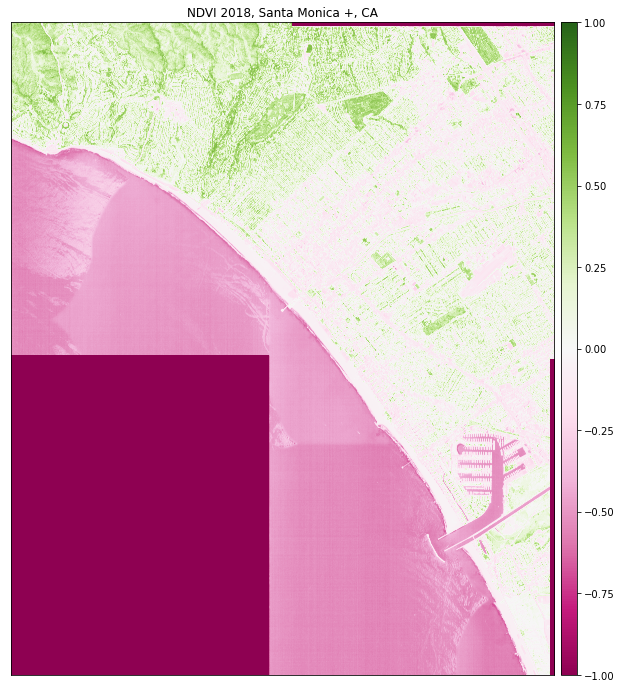

In [8]:
ep.plot_bands(ndvi, cmap='PiYG', scale=False, vmin=-1, vmax=1, title='NDVI 2018, Santa Monica +, CA');

Examine histogram to determine a good cuttoff value for the mask.

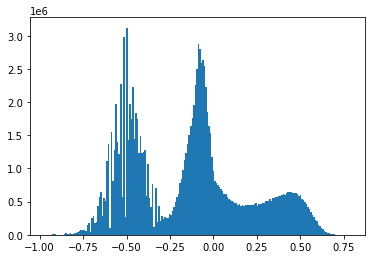

In [9]:
import matplotlib.pyplot as plt
ax = plt.hist(ndvi[ndvi > -8], bins=200);

It looks like the bottom bump is water, the middle bump is built environment and the upper bumb is vegetation.  Lets use 0.25 as a cuttoff for masking. the CHM.  But first we will write a geotiff of ndvi.

In [10]:
thresh = 0.25
mask = ndvi > thresh
rio.dtypes.can_cast_dtype(mask, 'uint8')

True

In [11]:
mask_file = f'mask_{str(thresh)}.tif'
profile['count'] = 1
mask = mask.reshape(1, 14334, 11946)

with rio.open(mask_file, 'w', **profile) as dst:
    dst.write(mask.astype(rio.uint8))

import fiona
from pyproj import Proj, transform
from fiona.crs import from_epsg

original = Proj(shape.crs) # EPSG:4326 in your case
destination = Proj(init='EPSG:...') # your new EPSG
with fiona.open('new.shp', 'w', 'ESRI Shapefile', shape.schema.copy(), crs=from_epsg(...)) as output:
    for feat in shape:
        long,lat =  feat['geometry']['coordinates']
        x,y = transform(original, destination,long,lat)
        # change only the coordinates of the feature
        feat['geometry']['coordinates'] = (x,y)
        output.write(feat)

outfile = 'santa_monica_4bandNAIP_mosaic_originwarp_1m_ndvi.tif'
chm_path = f'{filepath}/santa_monica_mosaic_35mlimit_originwarp.tiff'
extent_path = os.path.join(filepath, 'santa_monica_bbox', 'santa_monica_bbox.shp')

with fiona.open(extent_path, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    

with rio.open(mask_file, 'r') as mask:
    with rio.open(chm_path, 'r') as src:
        cropped_image, cropped_transform = rio.mask.mask(src, shapes, crop=True)
        meta = src.meta
        print(type(mask.read() * cropped_image.read()))

I cropped the mask in qgis

In [12]:
import subprocess

In [13]:
tmp = '/home/jovyan/tmp'
os.makedirs(tmp, exist_ok=True)

chm_path = f'{filepath}/santa_monica_mosaic_35mlimit_originwarp.tiff'
alligned_mask = f'{tmp}/alligned_mask.tif'
cropped_mask = f'{tmp}/cropped_mask.tif'

cmd = f'gdaltindex {tmp}clipper.shp {chm_path}'
subprocess.run(cmd, shell=True, capture_output=True)

cmd = f'gdalwarp -tr 1 1 -tap {mask_file} {alligned_mask}'
subprocess.run(cmd, shell=True, capture_output=True)

cmd = f'gdalwarp -cutline {tmp}/clipper.shp -crop_to_cutline {alligned_mask} {cropped_mask}'
subprocess.run(cmd, shell=True, capture_output=True)


CompletedProcess(args='gdalwarp -cutline /home/jovyan/tmp/clipper.shp -crop_to_cutline /home/jovyan/tmp/alligned_mask.tif /home/jovyan/tmp/cropped_mask.tif', returncode=1, stdout=b'', stderr=b'ERROR 1: Output dataset /home/jovyan/tmp/cropped_mask.tif exists,\nbut some command line options were provided indicating a new dataset\nshould be created.  Please delete existing dataset and run again.\n\n')

In [15]:
masked = 'santa_monica_mosaic_35mlimit_originwarp_NDVI_thresh25_masked.tiff'

with rio.open(cropped_mask, 'r') as mask:
    with rio.open(chm_path, 'r') as src:
        masked_arr = mask.read() * src.read()
        profile = src.profile
        with rio.open(masked, 'w', **profile) as dst:
            dst.write(masked_arr) 